In [46]:
# Importing Modules required to execute this piece of code
import mxnet as mx
from mxnet import gluon, nd, autograd
mx.random.seed(1)
import matplotlib.pyplot as plt
import numpy as np

In [33]:
from mxnet import gluon, nd, autograd

In [47]:
# Importing the newly added Loss function
from mxnet.gluon.loss import PoissonNLLLoss

In [48]:
# defining context and other input features and stuff
num_examples = 50000
num_features = 2
epochs = 10
num_outputs = 1
model_ctx = mx.cpu()
data_ctx = mx.cpu()

# Generating "Random" dataset

In [36]:
# Random sampling for X 
X = nd.random.poisson(shape=(num_examples,num_features), ctx = data_ctx)
y = nd.random.poisson(lam =3,shape=(num_examples,))

In [37]:
X.shape, y.shape

((50000, 2), (50000,))

In [38]:
batch_size = 20

In [39]:
# Generate the training set usin ArrayDataSet
training_set = gluon.data.DataLoader(gluon.data.ArrayDataset(X,y), shuffle=True, batch_size = batch_size )

# Creating a simple network

In [40]:
net = gluon.nn.Sequential()
#Add a sequence of layers.
net.add(
    gluon.nn.Dense(1),
    #nn.Dense(1, activation=)
)

net

Sequential(
  (0): Dense(None -> 1, linear)
)

In [49]:
# Defining the output function
def poissonloss_hidden(X):
    yhat1 = net(X);
    yhat = nd.exp(yhat1)
    return yhat

# Deferred Initialization of parameters- weights and bias

In [50]:
net.collect_params().initialize(mx.init.Normal(sigma=0.1), ctx=mx.cpu())

/Users/gireeg/Desktop/Internship/mxnetrepo/incubator-mxnet/python/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'dense2_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/gireeg/Desktop/Internship/mxnetrepo/incubator-mxnet/python/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'dense2_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


# Defining trainer

In [43]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

# Defining Loss function as PoissonNLLLoss

In [51]:
poisson_loss = PoissonNLLLoss(from_logits=False)

# Executing the Training Loop

In [ ]:
epochs = 10
loss_sequence = []
loss_seq = []
niter = 0
epochslist = []
num_batches = num_examples / batch_size
smoothing_constant = 0.5
moving_loss = 0
ops = []

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(training_set):

        with autograd.record():
            output = poissonloss_hidden(data)
            loss =  poisson_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        loss_seq.append(est_loss)
        cumulative_loss += nd.mean(loss).asscalar()
    ops.append(output.mean())
    if e % 10 == 0:    
        print("Epoch %s, loss: %s" % (e, cumulative_loss / num_examples))
    print(output.mean())
    loss_sequence.append(cumulative_loss / num_examples)
    epochslist.append(e)

Epoch 0, loss: -0.012113481574897595

[2.96558]
<NDArray 1 @cpu(0)>

[2.9257665]
<NDArray 1 @cpu(0)>

[3.02578]
<NDArray 1 @cpu(0)>

[2.958741]
<NDArray 1 @cpu(0)>


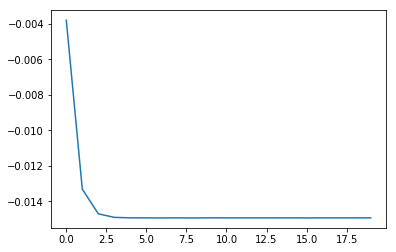

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(epochslist,loss_sequence)